In [1]:
import torch
import time
import random
import argparse
import math
import os
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from scipy import stats
from tqdm import tqdm
from collections import OrderedDict
from torchsummary import summary
from torch.backends import cudnn
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from torch.utils.tensorboard import SummaryWriter
import pickle
import scipy.io

from google.colab import drive
import sys
drive.mount("/content/drive", force_remount=True)

main_path = '/content/drive/My Drive/PINN/' # ENZE marked: you need to change your main_path if it's not here
sys.path.append(main_path)
from cyclic_lr_scheduler import CyclicLR
from utils import draw_two_dimension, draw_two_dimension_different_x

Mounted at /content/drive


In [2]:
class ConfigAD:
   def __init__(self):
        # print("--------------------------------------------------call init--------------------------------------------------")
        self.T_all = 163.0
        self.T = 163.0 # collocation point?
        self.T_unit = 0.1
        self.T_N = int(self.T / self.T_unit)
        self.N = int(self.T / self.T_unit) #184 #int(self.T / self.T_unit)

        self.Node = 3
        np.random.seed(0)

        self.ub = self.T
        self.lb = 0.0

        self.only_truth_flag = False  # True means only using loss_1 for truth_rate = 1.00, no other loss
        self.truth_rate = 1 #0.0034 # 0.0034 * 300 = 1 point(s) as truth #1.00 #0.25 #0.0005
        self.truth_length = int(self.truth_rate * self.T / self.T_unit)
        if not self.only_truth_flag:
            print("self.truth_length: {} of {} all ".format(self.truth_length, self.T_N))

        self.continue_period = 0.2
        self.round_bit = 3
        self.continue_id = None
        self.mapping_overall_flag = False
        self.loss2_partial_flag = False


In [ ]:
torch.abs(torch.randn(1))

tensor([0.4437])

In [3]:
def block_design_a(network_unit, sig):
    # print("--------------------------------------------------call block design a--------------------------------------------------")
    return nn.Sequential((OrderedDict({
      'lin1': nn.Linear(1, network_unit),
      'sig1': sig,
      'lin2': nn.Linear(network_unit, network_unit),
      'sig2': sig,
      'lin3': nn.Linear(network_unit, network_unit),
      'sig3': sig,
      'lin4': nn.Linear(network_unit, 1),
    })))

In [ ]:
torch.abs(torch.rand(1))

tensor([0.8129])

In [4]:
class SimpleNetworkAD(nn.Module):
  def __init__(self, config):
        # print("--------------------------------------------------call init of SimpleNetwork AD--------------------------------------------------")
        super(SimpleNetworkAD, self).__init__()
        self.setup_seed(0)
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.x, self.y0, self.t0 = None, None, None
        self.generate_x()
        # self.optimizer = optim.LBFGS(self.parameters(), lr=0.001, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100, line_search_fn=None)
        self.initial_start()
        self.model_name = "SimpleNetworkAD"
        self.gt = GroundTruthAD(self.config.T, self.config.T_N)
        self.gt_data = torch.Tensor(self.gt.data).to(self.device)
        # self.gt_v = torch.Tensor(self.gt.v).to(self.device)


        # parameters
        mat = scipy.io.loadmat(main_path+'Data/20220923YOUT.mat')
        parameters = torch.Tensor(mat['parameters']).float().reshape(18)

        print(parameters.size())
        # Amyloid
        self.k_a = parameters[0];
        self.k_ta = parameters[1];
        self.k_mt = parameters[2];
        self.d_a = parameters[3];
        self.theta = parameters[4];
        # Tau
        self.k_t = parameters[5];
        self.k_at = parameters[6];
        self.k_ma = parameters[7];
        self.d_t = parameters[8];
        self.delta = parameters[9];
        # Neurodegeneration
        self.k_r = parameters[17];
        self.k_tn = parameters[10];
        self.k_mtn = parameters[11];
        self.gamma = parameters[12];
        self.k_an = parameters[13];
        self.k_man = parameters[14];
        self.beta = parameters[15];
        self.k_atn = parameters[16];

        self.Laplacian = torch.Tensor(mat['avgNet']).float().to(self.device)[0:10, 0:10]
        self.r = torch.Tensor(mat['avgNet']).float().to(self.device) #.reshape([1])

        self.k1 = nn.Parameter(torch.abs(torch.rand(1)))  #k_a
        self.k2 = nn.Parameter(torch.abs(torch.rand(1))) #k_t
        self.k3 = nn.Parameter(torch.abs(torch.rand(1))) #k_tn
        self.k4 = nn.Parameter(torch.abs(torch.rand(1))) #k_an
        self.k5 = nn.Parameter(torch.abs(torch.rand(1))) #k_atn

        self.sig = nn.Tanh()
        self.network_unit = 20

        # Design A
        A_blocks = [block_design_a(self.network_unit, self.sig) for i in range(184)] #for i in range(self.config.Node//3)
        T_blocks = [block_design_a(self.network_unit, self.sig) for i in range(184)] #for i in range(self.config.Node//3)
        N_blocks = [block_design_a(self.network_unit, self.sig) for i in range(184)] #for i in range(self.config.Node//3)

        self.sequences_A = nn.Sequential(*A_blocks)
        self.sequences_T = nn.Sequential(*T_blocks)
        self.sequences_N = nn.Sequential(*N_blocks)


  def forward(self, inputs, num_sub):
      # print("--------------------------------------------------call forward--------------------------------------------------")
      # print("input",inputs.size())
      A_input = inputs
      T_input = inputs
      N_input = inputs
      
      A_output = [] 
      T_output = []
      N_output = []  
      
      A_output = self.sequences_A[num_sub](A_input)
      T_output = self.sequences_T[num_sub](T_input)
      N_output = self.sequences_N[num_sub](N_input)
      
      outputs = torch.cat((A_output, T_output, N_output), 1)
      return outputs
  
  def generate_x(self):
      # print("--------------------------------------------------call generate x--------------------------------------------------")
      x = [[i*self.config.T_unit] for i in range(self.config.T_N)]  # toy
      x = np.asarray(x)
      x = self.encode_t(x)
      # print("continue_id = {}: [0, {}] is mapped to [{}, {}]".format(self.config.continue_id, self.config.T, len(x[0]), len(x[-1])))
      self.x = torch.Tensor(x).float().to(self.device)
      



  def initial_start(self):
      # print("--------------------------------------------------call initial start x--------------------------------------------------")

      mat = scipy.io.loadmat(main_path+'Data/20220923YOUT.mat')
      # self.t0 = torch.Tensor(np.asarray(np.asarray([[np.random.rand()] * 1630] * (self.config.Node)).reshape([1630,1]))).float().to(self.device)#
      
      # print("initial start t0", self.t0.size())
      # # self.y0 = torch.Tensor(mat['gt_data'][:,:,0]).reshape([184,3]).float().to(self.device)
      # print("initial start y0", self.t0.size())


  def encode_t(self, num):
    return num / self.config.T_all * 2.0 

  def decode_t(self, num):
      return (num ) / 2.0 * self.config.T_all

  # def loss_only_ground_truth(self):
  #   # print("--------------------------------------------------call loss only ground truth--------------------------------------------------")
  #   self.eval()
  #   y = self.forward(self.x)
  #   self.loss_norm = torch.nn.MSELoss().to(self.device)
  #   # print(y.shape, self.gt_data.shape)
  #   loss = self.loss_norm(y, self.gt_data)


  #   A = y[:, 0:10]
  #   T = y[:, 10:20]
  #   N = y[:, 20:30]


  #   A_t_collection, T_t_collection, N_t_collection, C_t_collection = [], [], [], []

  #   for ii in range(self.config.Node//4):
  #     A_t_collection.append(torch.gradient(A[:,ii:ii+1].reshape([self.config.T_N]), spacing=(self.encode_t(self.x)[:, 0:1].reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1]))  # u_t = y_t[:, 0:1]
  #     T_t_collection.append(torch.gradient(T[:,ii:ii+1].reshape([self.config.T_N]), spacing=(self.encode_t(self.x)[:, 0:1].reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1]))  # u_t = y_t[:, 0:1]
  #     N_t_collection.append(torch.gradient(N[:,ii:ii+1].reshape([self.config.T_N]), spacing=(self.encode_t(self.x)[:, 0:1].reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1]))  # u_t = y_t[:, 0:1]

  #   A_t = torch.cat(A_t_collection, 1)
  #   T_t = torch.cat(T_t_collection, 1)
  #   N_t = torch.cat(N_t_collection, 1)

    
  #   mat = scipy.io.loadmat(main_path+'Data/20220822truth40.mat')
  #   Laplacian = torch.Tensor(mat['avgNet']).float().to(self.device)[0:10, 0:10]
  #   resil = scipy.io.loadmat(main_path+'Data/20220822truth40.mat')
  #   r = torch.Tensor(resil['r']).float().to(self.device).reshape([10])

  #   # f_a = A_t - (self.k1*A*(1 - A) + (self.config.k_ta*torch.pow(T,self.config.theta)) / (np.power((self.config.k_mt),self.config.theta) + torch.pow(T,self.config.theta)) - self.config.d_a*torch.matmul(A,Laplacian))
 
  #   # f_t = T_t - (self.config.k_t*T*(1 - T) + (self.config.k_at*torch.pow(A,self.config.delta)) / (np.power((self.config.k_ma),self.config.delta) + torch.pow(A,self.config.delta)) - self.config.d_t*torch.matmul(T,Laplacian))
  #   # f_n = N_t - ((self.config.k_tn*torch.pow(T,self.config.gamma)) / (np.power((self.config.k_mtn),self.config.gamma) + torch.pow(T,self.config.gamma))+ 
  #   #              (self.config.k_an*torch.pow(A,self.config.beta)) / (np.power((self.config.k_man),self.config.beta) + torch.pow(A,self.config.beta))+ 
  #   #              self.config.k_atn*A*T)
  #   # f_c = C_t - (- self.config.k_r*r + (self.config.k_nc*torch.pow(N,self.config.alpha)) / (np.power((self.config.k_mn),self.config.alpha) + torch.pow(N,self.config.alpha)))
   

  #   # f_a = A_t - (self.k1*A*(1 - A) + (self.config.k_ta*torch.pow(T,self.config.theta)) / (np.power((self.config.k_mt),self.config.theta) + torch.pow(T,self.config.theta)) - self.config.d_a*torch.matmul(A,Laplacian))
 
  #   # f_t = T_t - (self.config.k_t*T*(1 - T) + (self.config.k_at*torch.pow(A,self.config.delta)) / (np.power((self.config.k_ma),self.config.delta) + torch.pow(A,self.config.delta)) - self.config.d_t*torch.matmul(T,Laplacian))
  #   # f_n = N_t - ((self.config.k_tn*torch.pow(T,self.config.gamma)) / (np.power((self.config.k_mtn),self.config.gamma) + torch.pow(T,self.config.gamma))+ 
  #   #              (self.config.k_an*torch.pow(A,self.config.beta)) / (np.power((self.config.k_man),self.config.beta) + torch.pow(A,self.config.beta))+ 
  #   #              self.config.k_atn*A*T)
  #   # f_c = C_t - (- self.config.k_r*r + (self.config.k_nc*torch.pow(N,self.config.alpha)) / (np.power((self.config.k_mn),self.config.alpha) + torch.pow(N,self.config.alpha)))
   

  #   # f_y = torch.cat((f_a, f_t, f_n, f_c), 1)
  #   # zeros_2 = torch.Tensor([[0.0 for i in range(self.config.Node//4 )] for j in range( self.config.N )]).to(self.device)
  #   # zeros_2D = torch.Tensor([[0.0 for i in range(self.config.Node )] for j in range( self.config.N )]).to(self.device)
    
  #   # loss_2 = self.loss_norm(f_y, zeros_2D)  # + torch.var(torch.square(f_y))
  #   self.train()

  #   return loss, [loss, loss_2], []
  

  def loss(self):
    # print("--------------------------------------------------call loss --------------------------------------------------")
    self.eval()
    all_loss, all_loss1, all_loss2, all_loss3 = torch.tensor([0.0]),torch.tensor([0.0]),torch.tensor([0.0]),torch.tensor([0.0])
    for num_sub in range(184):
      y = self.forward(self.x, num_sub)
      # print("output x" , self.x.size())
      # print("output y" ,y.size())
      A = y[:,0:1]
      T = y[:,1:2]
      N = y[:,2:3]

      A_t = torch.gradient(A.reshape([self.config.T_N]), spacing=(self.decode_t(self.x).reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1])
      T_t = torch.gradient(T.reshape([self.config.T_N]), spacing=(self.decode_t(self.x).reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1])
      N_t = torch.gradient(N.reshape([self.config.T_N]), spacing=(self.decode_t(self.x).reshape([self.config.T_N]),))[0].reshape([self.config.T_N,1])
      
      # print("--------------------------------------------------call f_a --------------------------------------------------")

      f_a = A_t - (self.k1*A*(1 - A) + (self.k_ta*torch.pow(T,self.theta)) / (np.power((self.k_mt),self.theta) + torch.pow(T,self.theta))) #- self.config.d_a*torch.matmul(A,self.Laplacian))
      f_t = T_t - (self.k2*T*(1 - T) + (self.k_at*torch.pow(A,self.delta)) / (np.power((self.k_ma),self.delta) + torch.pow(A,self.delta))) #- self.config.d_t*torch.matmul(T,self.Laplacian))
      f_n = N_t - ((self.k3*torch.pow(T,self.gamma)) / (np.power((self.k_mtn),self.gamma) + torch.pow(T,self.gamma))+ 
                  (self.k4*torch.pow(A,self.beta)) / (np.power((self.k_man),self.beta) + torch.pow(A,self.beta))+ 
                  self.k5*A*T)
      f_y = torch.cat((f_a, f_t, f_n), 1)
    

      # print("--------------------------------------------------calculate gradient--------------------------------------------------")

      # L2 norm
      self.loss_norm = torch.nn.MSELoss().to(self.device)
      zeros_1D = torch.Tensor([[0.0]] * self.config.N).to(self.device)

      zeros_2D = torch.Tensor([[0.0 for i in range(self.config.Node )] for j in range( self.config.N )]).to(self.device)
      
      # print(y.shape, self.gt_data.shape)
      # print("loss-y",y.cpu().detach().numpy()[1, :],y.cpu().detach().numpy()[100, :],y.cpu().detach().numpy()[1000, :],y.cpu().detach().numpy()[1600, :])
      # print("loss-truey",self.gt_data[num_sub,1, :],self.gt_data[num_sub,100, :],self.gt_data[num_sub,1000, :],self.gt_data[num_sub,1600, :])
      loss_1 = self.loss_norm(y[:self.config.truth_length, :], self.gt_data[num_sub,:self.config.truth_length,:])

      
      
      if self.config.loss2_partial_flag:
          new_period = int(self.config.continue_period * self.config.T_all / self.config.T_unit)
          loss_2 = self.loss_norm(f_y[-new_period:, :], zeros_2D[-new_period:, :])
      else:
          loss_2 = self.loss_norm(f_y, zeros_2D)  # + torch.var(torch.square(f_y))

      loss_3 = self.loss_norm(torch.abs(y[:self.config.truth_length, :]-0.3), y[:self.config.truth_length, :]-0.3)*1e5

      loss = (loss_1 + loss_2 + loss_3) # + loss_3)#+ loss_4 + loss_5) / 1e5
      all_loss += loss
      all_loss1 += loss_1
      all_loss2 += loss_2
      all_loss3 += loss_3
      
      
    self.train()
    return all_loss, [all_loss1, all_loss2, all_loss3], []
    # return torch.mean(torch.square(y_hat - y))
    # return F.mse_loss(torch.cat((u_hat, v_hat), 1), torch.cat((u, v), 1))
    # return torch.abs(u_hat - u) + torch.abs(v_hat - v)  # F.mse_loss(x_hat, x) + beta * self.kl_div(rho)
  
  @staticmethod
  def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True
  

In [5]:
z = []
z.append([1,1,1])
z.append([1,2,3])
z = np.array(z)
sum(z[:,])

array([2, 3, 4])

In [6]:
class GroundTruthAD:
  def __init__(self, t_max, length):

    mat = scipy.io.loadmat(main_path+'Data/20220923YOUT.mat')
    # self.t0 = torch.Tensor(np.asarray(np.asarray([np.random.rand()] * (self.config.Node)).reshape([1, -1]))).float().to(self.device)#
    # self.y0 = torch.Tensor(mat['YOUT'][0,:]).reshape([1, -1]).float().to(self.device)
    x = torch.Tensor(mat['pred']).float()

    # for i in range(x.size()[0]):
    #   plt.plot(x[i, :,0])
    # plt.show()


    # for i in range(x.size()[0]):
    #   plt.plot(x[i, :,1])
    # plt.show()


    # for i in range(x.size()[0]):
    #   plt.plot(x)
    
    print("----------------------------- ground truth ------------------------------------")
    self.data = torch.Tensor(mat['pred'][:,1:,:].reshape(184,1630,3)).float()

    print("--------------------------------------------------------------------------")


def get_now_string():
    return time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime(time.time()))


In [7]:
def train_ad(model, args, config, now_string):
    # print("--------------------------------------------------call train AD--------------------------------------------------")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    model.train()
    model_save_path_last = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_last.pt"
    model_save_path_best = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_best.pt"
    loss_save_path = f"{args.main_path}/loss/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_loss_{args.epoch}.npy"
    board_save_path = f"{args.main_path}/board/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_board"
    print("using " + str(device))
    print("epoch = {}".format(args.epoch))
    print("epoch_step = {}".format(args.epoch_step))
    print("model_name = {}".format(model.model_name))
    print("now_string = {}".format(now_string))
    print("model_save_path_last = {}".format(model_save_path_last))
    print("model_save_path_best = {}".format(model_save_path_best))
    print("loss_save_path = {}".format(loss_save_path))
    print("args = {}".format({item[0]: item[1] for item in args.__dict__.items() if item[0][0] != "_"}))
    print("config = {}".format({item[0]: item[1] for item in config.__dict__.items() if item[0][0] != "_"}))
    print("ONLY TRUTH FLAG: ", )
    # gt = GroundTruthPP(config.T, config.N)
    writer = SummaryWriter(board_save_path)

    # optimizer = optim.Adam(model.parameters(), lr=args.lr)
    initial_lr = args.lr
    optimizer = optim.Adam(model.parameters(), lr = initial_lr)

    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch/10000+1)) # decade
    # scheduler = CyclicLR(optimizer, base_lr=0.001, max_lr=0.01, step_size=10000) # cyclic
    epoch_step = args.epoch_step
    start_time = time.time()
    start_time_0 = start_time
    best_loss = 999999
    now_time = 0
    loss_record = []
    param_ka = []
    
    print("--------------------------------------------------training start--------------------------------------------------")

    for epoch in range(1, args.epoch + 1):
        # print("in epoch ", epoch)
        optimizer.zero_grad()
        inputs = model.x
        outputs = model(inputs,0)
        if config.only_truth_flag:
          # print("--------------------------------------------------loss only ground truth--------------------------------------------------")
          loss, loss_list, _ = model.loss_only_ground_truth()
        else:
          # print("--------------------------------------------------normal loss--------------------------------------------------")
          loss, loss_list, _ = model.loss()
        writer.add_scalar('Loss/train', loss.item(), epoch)
        
        # loss_1, loss_2, loss_3 = loss_list[0], loss_list[1], loss_list[2]
        loss.backward()
        # print("loss backward")
        # options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}
        # _loss, _, lr, _, F_eval, G_eval, _, _ = optimizer.step(closure)
        optimizer.step()
        scheduler.step()
        loss_record.append(float(loss.item()))
        param_ka.append(float(model.k5.item()))
        if epoch % epoch_step == 0:
            now_time = time.time()
            loss_print_part = " ".join(["Loss_{0:d}:{1:.6f}".format(i + 1, loss_part.item()) for i, loss_part in enumerate(loss_list)])
            # print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} Loss_1:{3:.6f} Loss_2:{4:.6f} Loss_3: {5:.6f} Lr:{6:.6f} Time:{7:.6f}s ({8:.2f}min in total)".format(epoch, args.epoch, loss.item(), loss_1.item(), loss_2.item(), loss_3.item(), optimizer.param_groups[0]["lr"], now_time - start_time, (now_time - start_time_0) / 60.0))
            print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} {3} Lr:{4:.6f} Time:{5:.6f}s ({6:.2f}min in total, {7:.2f}min remains)".format(epoch, args.epoch, loss.item(), loss_print_part, optimizer.param_groups[0]["lr"], now_time - start_time, (now_time - start_time_0) / 60.0, (now_time - start_time_0) / 60.0 / epoch * (args.epoch - epoch)))
            print("True: ",  model.k_a,"; estimated: ", model.k1.item())
            print("True: ",  model.k_t,"; estimated: ", model.k2.item())
            print("True: ",  model.k_tn,"; estimated: ", model.k3.item())
            print("True: ",  model.k_an,"; estimated: ", model.k4.item())
            print("True: ",  model.k_atn,"; estimated: ", model.k5.item())
            print("----------------------------")
            start_time = time.time()
            torch.save(
                {
                    'epoch': args.epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item()
                }, model_save_path_last)
            # print(inputs.shape)
            if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(
                    {
                        'epoch': args.epoch,
                        'model_state_dict': model.state_dict(),
                        # 'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss.item()
                    }, model_save_path_best)
        if epoch % args.save_step == 0:
            test_ad(model, args, config, now_string,param_ka, True, model.gt, None)

            # np.save(loss_save_path, np.asarray(loss_record))
    
    num_parameter = -1  # get_model_parameters(model, config)
    best_loss = best_loss
    time_cost = (now_time - start_time_0) / 60.0
    loss_record = np.asarray(loss_record)
    np.save(loss_save_path, loss_record)
    # draw_loss(loss_record)
    print("tensor board path: {}".format(board_save_path))
    print("%load_ext tensorboard")
    print("%tensorboard --logdir={}".format(board_save_path.replace(" ", "\ ")))
    # return [num_parameter, best_loss, time_cost, loss_record]
    return model


def draw_loss(loss_list):
    map = np.asarray([[loss] for loss in loss_list])
    plt.plot(map)
    plt.show()
    plt.clf()

In [8]:
def test_ad(model, args, config, now_string, param_ka ,show_flag=True, gt=None, loss_2_details=None):
    # print("--------------------------------------------------call test ad--------------------------------------------------")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    # model_save_path = f"{args.main_path}train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_last.pt"
    # model.load_state_dict(torch.load(model_save_path, map_location=device)["model_state_dict"])
    model.eval()
    print("Testing & drawing...")
    t = model.x
    y = model(t,1)
    # y0_pred = model(model.t0)
    print(t.shape,y.shape)
    x = [item[0] for item in model.decode_t(t).cpu().detach().numpy()]
   
    plt.figure(figsize=(16,6))
    ax1 = plt.subplot(1, 2, 1)
    
    
    ax1.plot(x, y.cpu().detach().numpy()[:,0], 'b')
    ax1.plot(x, y.cpu().detach().numpy()[:,1], 'g')
    ax1.plot(x, y.cpu().detach().numpy()[:,2], 'y')
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(np.asarray(param_ka))

    plt.show()
    plt.close()
   
   

In [ ]:
# test_ad(model, args, self.config, now_string=get_now_string())

In [9]:
class Args:
    epoch = 20000
    epoch_step = 2000
    lr = 0.003
    main_path = "."
    save_step = 5000

class TestArgs:
    epoch = 1
    epoch_step = 1
    lr = 0.03
    main_path = "."
    save_step = 1


def run_ad_truth(main_path=None):
    # print("--------------------------------------------------call run ad truth--------------------------------------------------")
    args = Args
    if main_path:
        args.main_path = main_path
    if not os.path.exists("{}/train".format(args.main_path)):
        os.makedirs("{}/train".format(args.main_path))
    if not os.path.exists("{}/figure".format(args.main_path)):
        os.makedirs("{}/figure".format(args.main_path))
    if not os.path.exists("{}/loss".format(args.main_path)):
        os.makedirs("{}/loss".format(args.main_path))
    now_string = get_now_string()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    config = ConfigAD()
    model = SimpleNetworkAD(config).to(device)
    model = train_ad(model, args, config, now_string)
    
    print("weight1:", model.config.k_a.cpu().detach().numpy().flatten())

    print("----------------------------truth-----------------------------------------")
    print("--------------------------------------------------------------------------")

    mat = scipy.io.loadmat(main_path+'Data/20220822truth40.mat')
    x = torch.Tensor(mat['YOUT']).float()
    plt.plot(x[:,0:10], 'b')
    plt.plot(x[:,10:20], 'g')
    plt.plot(x[:,20:30], 'y')
    plt.plot(x[:,30:40], 'c')
    plt.show()

    return model


self.truth_length: 1630 of 1630 all 
----------------------------- ground truth ------------------------------------
--------------------------------------------------------------------------
torch.Size([18])
using cpu
epoch = 20000
epoch_step = 2000
model_name = SimpleNetworkAD
now_string = 2022-10-01-21-13-47
model_save_path_last = /content/drive/My Drive/PINN//train/SimpleNetworkAD_20000_2000_0.003_2022-10-01-21-13-47_last.pt
model_save_path_best = /content/drive/My Drive/PINN//train/SimpleNetworkAD_20000_2000_0.003_2022-10-01-21-13-47_best.pt
loss_save_path = /content/drive/My Drive/PINN//loss/SimpleNetworkAD_20000_2000_0.003_2022-10-01-21-13-47_loss_20000.npy
args = {'epoch': 20000, 'epoch_step': 2000, 'lr': 0.003, 'main_path': '/content/drive/My Drive/PINN/', 'save_step': 5000}
config = {'T_all': 163.0, 'T': 163.0, 'T_unit': 0.1, 'T_N': 1630, 'N': 1630, 'Node': 3, 'ub': 163.0, 'lb': 0.0, 'only_truth_flag': False, 'truth_rate': 1, 'truth_length': 1630, 'continue_period': 0.2, 'rou

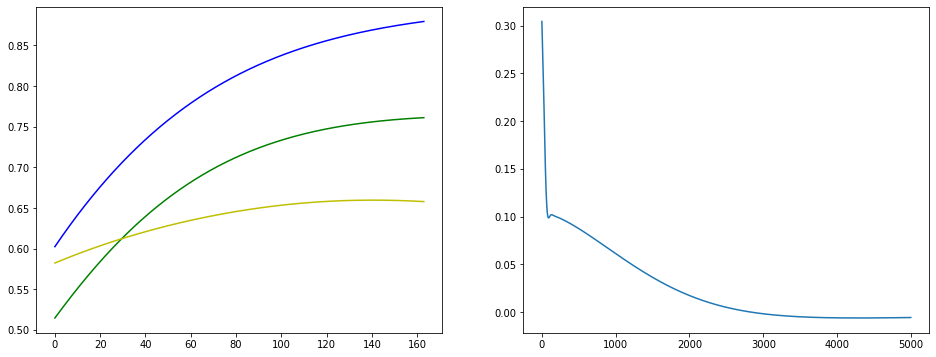

Epoch [06000/20000] Loss:4.325058 Loss_1:4.324783 Loss_2:0.000249 Loss_3:0.000027 Lr:0.001875 Time:3880.225345s (194.75min in total, 454.42min remains)
True:  tensor(1.0000e-04) ; estimated:  -9.575290459906682e-05
True:  tensor(0.0039) ; estimated:  0.0006390411872416735
True:  tensor(0.0023) ; estimated:  0.004208088852465153
True:  tensor(0.0012) ; estimated:  0.0044815693981945515
True:  tensor(0.0012) ; estimated:  -0.004412171430885792
----------------------------
Epoch [08000/20000] Loss:0.945257 Loss_1:0.944951 Loss_2:0.000204 Loss_3:0.000102 Lr:0.001667 Time:3944.339077s (260.49min in total, 390.74min remains)
True:  tensor(1.0000e-04) ; estimated:  -0.0005160214495845139
True:  tensor(0.0039) ; estimated:  0.0007740171276964247
True:  tensor(0.0023) ; estimated:  0.0027274673338979483
True:  tensor(0.0012) ; estimated:  0.003717712825164199
True:  tensor(0.0012) ; estimated:  -0.00249274680390954
----------------------------
Epoch [10000/20000] Loss:0.404273 Loss_1:0.403950 L

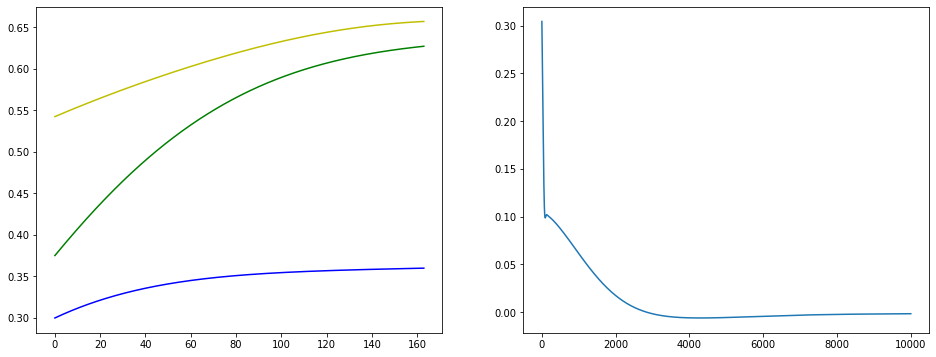

Epoch [12000/20000] Loss:0.336690 Loss_1:0.336420 Loss_2:0.000174 Loss_3:0.000097 Lr:0.001364 Time:3866.181835s (389.76min in total, 259.84min remains)
True:  tensor(1.0000e-04) ; estimated:  -0.0003040007723029703
True:  tensor(0.0039) ; estimated:  0.0020883132237941027
True:  tensor(0.0023) ; estimated:  0.002361118793487549
True:  tensor(0.0012) ; estimated:  0.0037438010331243277
True:  tensor(0.0012) ; estimated:  -0.001524651306681335
----------------------------


In [ ]:
################ truth rate = 1
mode1_1 = run_ad_truth(main_path)

In [ ]:
x.shape

In [ ]:
# truth rt = 0.1 
mode1_3 = run_ad_truth(main_path)

In [ ]:
# truth rt = 0.1; 5 parameters
mode1_4 = run_ad_truth(main_path)

In [ ]:
# truth rt = 1; 5 parameters
mode1_4 = run_ad_truth(main_path)

In [ ]:
# truth rt = 1; 5 parameters
mode1_5 = run_ad_truth(main_path)